In [1]:
import pandas as pd
import datetime as dt
import seaborn as sns
import numpy as np
from matplotlib import pyplot as plt
from RandomForestForTimeSeriesRegressor import RandomForestForTimeSeriesRegressor, BLOCK_TYPES

In [2]:
dataset = pd.read_csv('yahoo_dataset.csv')

In [3]:
dataset = dataset.dropna()
dataset = dataset.sort_values("Date")
dataset

,Date,Ticker,Open,High,Low,Close,Adj_close,Volume
2285919,1 abr 1970,ED,6.94,6.97,6.88,6.94,0.24,40400
2262652,1 abr 1970,HPQ,0.31,0.32,0.31,0.32,0.11,2578982
808675,1 abr 1970,BA,0.75,0.75,0.74,0.74,0.22,473850
1281914,1 abr 1970,MMM,5.49,5.59,5.49,5.55,1.01,288954
203874,1 abr 1970,CVX,2.78,2.84,2.78,2.84,0.37,1028800
...,...,...,...,...,...,...,...,...
3206090,9 sept 2024,JBHT,167.67,171.95,167.67,171.74,170.90,615800
2235682,9 sept 2024,DD,79.60,80.79,79.46,79.56,78.80,2999700
1768355,9 sept 2024,ODFL,185.98,190.99,185.77,189.78,189.25,1445200
3037329,9 sept 2024,CMS,68.00,69.24,67.85,69.12,68.06,2466300


In [4]:
from dateutil import parser

# Diccionario para traducir meses en español a inglés
MESES_ESP = {
    "ene": "Jan", "feb": "Feb", "mar": "Mar", "abr": "Apr", "may": "May", "jun": "Jun",
    "jul": "Jul", "ago": "Aug", "sep": "Sep", "oct": "Oct", "nov": "Nov", "dic": "Dec"
}

# def corregir_fecha(fecha_str):
#     partes = fecha_str.split()
#     if len(partes) == 3:  # Asegurar que tiene día, mes y año
#         dia, mes, anio = partes
#         mes = MESES_ESP.get(mes.lower(), mes)  # Traducir mes al inglés
#         fecha_corregida = f"{dia} {mes} {anio}"
#         return parser.parse(fecha_corregida, dayfirst=True).toordinal()
#     return None  # Retorna None si no es válida
def corregir_fecha(fecha_str):
    try:
        partes = fecha_str.split()
        if len(partes) == 3:  # Asegurar que tiene día, mes y año
            dia, mes, anio = partes
            mes = MESES_ESP.get(mes.lower(), mes)  # Traducir mes al inglés
            fecha_corregida = f"{dia} {mes} {anio}"
            fecha_dt = parser.parse(fecha_corregida, dayfirst=True)  # Convertir a datetime
            return fecha_dt.strftime("%Y-%m-%d")  # Devolver en formato legible
    except Exception as e:
        print(f"Error con la fecha: {fecha_str} - {e}")
        return None  # Retorna None si hay un error

def actualizar_fecha(df, columna):
    df[columna] = df[columna].apply(lambda x: corregir_fecha(x) if pd.notna(x) else None)
    return df

dataset = actualizar_fecha(dataset, "Date")
dataset

,Date,Ticker,Open,High,Low,Close,Adj_close,Volume
2285919,1970-04-01,ED,6.94,6.97,6.88,6.94,0.24,40400
2262652,1970-04-01,HPQ,0.31,0.32,0.31,0.32,0.11,2578982
808675,1970-04-01,BA,0.75,0.75,0.74,0.74,0.22,473850
1281914,1970-04-01,MMM,5.49,5.59,5.49,5.55,1.01,288954
203874,1970-04-01,CVX,2.78,2.84,2.78,2.84,0.37,1028800
...,...,...,...,...,...,...,...,...
3206090,2024-09-09,JBHT,167.67,171.95,167.67,171.74,170.90,615800
2235682,2024-09-09,DD,79.60,80.79,79.46,79.56,78.80,2999700
1768355,2024-09-09,ODFL,185.98,190.99,185.77,189.78,189.25,1445200
3037329,2024-09-09,CMS,68.00,69.24,67.85,69.12,68.06,2466300


In [ ]:
def calculateFields(dataset):
    if 'Date' not in dataset:
        dataset['Date'] = dataset['date']
        dataset = dataset.drop(columns=["date"])
    if 'Adj Close' in dataset:
        dataset = dataset.drop(columns=['Adj Close'])
    if 'Adj Close' in dataset:
        dataset = dataset.drop(columns=['Adj_close'])
    dataset['Date'] = pd.to_datetime(dataset['Date'])
    dataset['DateOrdinal'] = dataset['Date'].map(dt.datetime.toordinal)
    dataset['average_price'] = dataset[['Low', 'High']].mean(axis=1)
    dataset = dataset.drop(columns=["Volume", "Close", "Open", "Low", "High"])
    dataset['DayOfWeek'] = dataset['Date'].dt.dayofweek
    dataset['Month'] = dataset['Date'].dt.month
    dataset['Year'] = dataset['Date'].dt.year
    dataset['DayOfYear'] = dataset['Date'].dt.dayofyear
    dataset['WeekOfYear'] = dataset['Date'].dt.isocalendar().week

    dataset['is_start_of_month'] = (dataset['Date'].dt.day == 1).astype(int)
    dataset['is_end_of_month'] = (dataset['Date'] == dataset['Date'] + pd.offsets.MonthEnd(0)).astype(int)
    dataset['quarter'] = dataset['Date'].dt.quarter
    def get_season(month):
        if month in [12, 1, 2]:
            return 0#'winter'
        elif month in [3, 4, 5]:
            return 1#'spring'
        elif month in [6, 7, 8]:
            return 2#'summer'
        else:
            return 3#'autumn'
    dataset['season'] = dataset['Month'].apply(get_season)
    dataset['SerieNumber'] = (dataset['Date'] - dataset['Date'].min()).dt.days + 1


    days_ago = 30

    dataset["price_30_days_ago"] = dataset["average_price"].shift(days_ago)
    dataset["price_180_days_ago"] = dataset["average_price"].shift(180)
    dataset["price_365_days_ago"] = dataset["average_price"].shift(365)


    dataset = dataset.dropna().reset_index(drop=True)
    if 'Symbol' in dataset:
        dataset['Symbol'] = pd.factorize(dataset.Symbol)[0]
    else:
        dataset['Symbol'] = pd.factorize(dataset.Ticker)[0]
        dataset = dataset.drop(columns=['Ticker'])

    return dataset

calculatedFields = ["DateOrdinal", "DayOfWeek", "Month", "Year", "DayOfYear", "WeekOfYear", "is_start_of_month", "is_end_of_month", "quarter",
                    "season", "SerieNumber", "price_30_days_ago", "price_180_days_ago", "price_365_days_ago", "Symbol"]
fieldsPrice = ["average_price"]


dataset = calculateFields(dataset)
dataset

,Date,Adj_close,DateOrdinal,average_price,DayOfWeek,Month,Year,DayOfYear,WeekOfYear,is_start_of_month,is_end_of_month,quarter,season,SerieNumber,price_30_days_ago,price_180_days_ago,price_365_days_ago,Symbol
0,1980-04-01,0.13,722906,0.175,1,4,1980,92,14,1,0,2,1,3743,0.610,2.205,6.925,0
1,1980-04-01,5.77,722906,16.880,1,4,1980,92,14,1,0,2,1,3743,11.960,1.720,0.315,1
2,1980-04-01,1.22,722906,5.180,1,4,1980,92,14,1,0,2,1,3743,7.640,4.875,0.745,2
3,1980-04-01,0.32,722906,1.255,1,4,1980,92,14,1,0,2,1,3743,6.315,2.595,5.540,3
4,1980-04-01,0.55,722906,1.655,1,4,1980,92,14,1,0,2,1,3743,3.435,1.020,2.810,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4051916,2024-09-09,170.90,739138,169.810,0,9,2024,253,37,0,0,3,3,19975,114.500,362.785,141.740,194
4051917,2024-09-09,78.80,739138,80.125,0,9,2024,253,37,0,0,3,3,19975,57.230,11.120,71.645,21
4051918,2024-09-09,189.25,739138,188.380,0,9,2024,253,37,0,0,3,3,19975,54.415,33.745,160.075,248
4051919,2024-09-09,68.06,739138,68.545,0,9,2024,253,37,0,0,3,3,19975,226.185,109.735,228.220,1


In [6]:
dataset['Symbol'] = pd.factorize(dataset.Symbol)[0]

In [7]:
trainPercent = 80
trainSamples = (len(dataset.index) // 100) * trainPercent
testSamples = len(dataset.index) - trainSamples

In [8]:
def getRandomBlock(dataset0, blockDayRange):
    max_date = pd.to_datetime(dataset0['Date'].max())
    min_valid_date = max_date - pd.DateOffset(years=1)  # Fecha máxima menos un año
    
    valid_dates = dataset0[dataset0['Date'] <= min_valid_date]['Date']
    if valid_dates.empty:
        raise ValueError("No hay fechas válidas en el rango permitido.")
    
    random_start_date = np.random.choice(valid_dates)
    end_date = random_start_date + pd.DateOffset(days=blockDayRange)
    
    filtered_df = dataset0[(dataset0['Date'] >= random_start_date) & (dataset0['Date'] <= end_date)]
    return filtered_df

In [9]:
def getRandomTrainTestData(dataset0, daysRange, trainDays):
    blockDf = getRandomBlock(dataset0, daysRange)
    min_date = pd.to_datetime(dataset0['Date'].min())
    train_max_day = min_date + pd.DateOffset(days=trainDays)
    trainSamples = dataset0[dataset0['Date'] < train_max_day].shape[0]
    testSamples = len(dataset0.index) - trainSamples

    aux = dataset0.copy()
    aux = aux.drop("Date", axis=1)
    X = aux[calculatedFields].copy()
    aux = aux.drop(calculatedFields, axis=1)

    Y = aux.copy()

    X_train = X.iloc[:trainSamples]
    Y_train = Y.iloc[:trainSamples]
    X_test = X.iloc[-testSamples:]
    Y_test = Y.iloc[-testSamples:]

    return X_train, Y_train, X_test, Y_test

In [10]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
from math import sqrt

basicRFPrecision = []
for i in range(50):
    X_train0, Y_train0, X_test0, Y_test0 = getRandomTrainTestData(dataset, 730, 365)
    basicRF = RandomForestRegressor(n_jobs=5, n_estimators=100, max_depth=10)
    basicRF.fit(X_train0, Y_train0)
    y_pred = basicRF.predict(X_test0)
    rmse0 = sqrt(mean_squared_error(Y_test0, y_pred))
    print(f"RMSE:")
    print(rmse0)
    basicRFPrecision.append(rmse0)

RMSE:
141.8449783554902
RMSE:
142.46960718014554
RMSE:
142.6082568961843
RMSE:
142.97202258894072
RMSE:
142.83774822706428
RMSE:
142.4982681830689
RMSE:
142.26107333421334
RMSE:
142.26073320117987
RMSE:
142.21276654030981
RMSE:
143.1542259037776
RMSE:
143.03218999059587
RMSE:
142.28480789242494
RMSE:
142.3020480622174
RMSE:
142.18317112725535
RMSE:
143.67174027618333
RMSE:
142.67442903754582
RMSE:
142.25926852478327
RMSE:
143.25604807442025
RMSE:
142.48503423701334
RMSE:
142.5540412085885
RMSE:
143.22382452167983
RMSE:
142.0764276687588
RMSE:
142.51899680874465
RMSE:
142.56446282684402
RMSE:
142.81703236237993
RMSE:
142.8602101401642
RMSE:
142.66151518238186
RMSE:
143.20104941427763
RMSE:
143.3183321276269
RMSE:
142.83590035329257
RMSE:
142.51631888991017
RMSE:
142.7218125895714
RMSE:
142.66024723211814
RMSE:
142.41327046418837
RMSE:
142.4859028984736
RMSE:
143.29551213115255
RMSE:
142.85635234265146
RMSE:
142.66627342474797
RMSE:
142.58686978664045
RMSE:
142.44475310613632
RMSE:
142.7

In [11]:
def warn(*args, **kwargs):
    pass
import warnings
warnings.warn = warn

In [12]:
daysOfBlocks = 730
daysOfTraining = 365
X_train0, Y_train0, X_test0, Y_test0 = getRandomTrainTestData(dataset, daysOfBlocks, daysOfTraining)
totalSamplesAprox = X_train0.shape[0]
blockSizes = [totalSamplesAprox / 100, totalSamplesAprox / 50, totalSamplesAprox / 25, totalSamplesAprox / 10, totalSamplesAprox / 5]
for i in range(len(blockSizes)):
    blockSizes[i] = int(blockSizes[i])


In [13]:
def testRftsAndGetRmseByAlgorithm(dataset0, daysOfBlocks0, daysOfTraining0, block_size0, algorithm0):
    X_train0, Y_train0, X_test0, Y_test0 = getRandomTrainTestData(dataset0, daysOfBlocks0, daysOfTraining0)
    rfts = RandomForestForTimeSeriesRegressor(n_jobs=5, n_estimators=100, block_size=block_size0, max_depth=10, block_type=BLOCK_TYPES[algorithm0])
    rfts.fit(X_train0, Y_train0)
    y_pred = rfts.predict(X_test0)
    rmse0 = sqrt(mean_squared_error(Y_test0, y_pred))
    return rmse0

In [ ]:
precisionNonOverlapping = dict()
for block_size in blockSizes:
    precisionNonOverlapping[block_size] = []
    for k in range(50):
        rmse0 = testRftsAndGetRmseByAlgorithm(dataset, daysOfBlocks, daysOfTraining, block_size, 0)
        print(f"RMSE: ({block_size}, {k})")
        print(rmse0)
        precisionNonOverlapping[block_size].append(rmse0)

RMSE: (48, 0)
143.40864698676944
RMSE: (48, 1)
142.75564798560734
RMSE: (48, 2)
143.3398543511592
RMSE: (48, 3)
142.6101528238899
RMSE: (48, 4)
143.31860323040826
RMSE: (48, 5)
143.3823568416953
RMSE: (48, 6)
143.8558778125786
RMSE: (48, 7)
143.70258075955346
RMSE: (48, 8)
143.4766060436772
RMSE: (48, 9)
142.8003569230518
RMSE: (96, 0)
143.5131245978179
RMSE: (96, 1)
143.67584869279574
RMSE: (96, 2)
143.43411000752994
RMSE: (96, 3)
142.60397004606457
RMSE: (96, 4)
143.21746378496954
RMSE: (96, 5)
143.15211289727023
RMSE: (96, 6)
143.71770090265582
RMSE: (96, 7)
143.59003833427596
RMSE: (96, 8)
143.48151928113737
RMSE: (96, 9)
143.7532392648106
RMSE: (192, 0)
142.20493081964497
RMSE: (192, 1)
143.1730334960521
RMSE: (192, 2)
142.35818079827627
RMSE: (192, 3)
142.76169135487453
RMSE: (192, 4)
143.56600541386595
RMSE: (192, 5)
143.00039626735014
RMSE: (192, 6)
143.3856926608729
RMSE: (192, 7)
143.20398187648073
RMSE: (192, 8)
143.2304632491955
RMSE: (192, 9)
142.86478470272215
RMSE: (480,

In [15]:
def getGraphData(presitionDataArray):
    all_arr = [basicRFPrecision]
    ticksIdx = [0]
    ticksNames = ["RF"]
    idx = 0
    for blockSize in blockSizes:
        
        data0 = []
        for r in presitionDataArray[blockSize]:
            data0.append(r)

        all_arr.append(data0)
        idx += 1
        ticksIdx.append(idx)
        ticksNames.append(str(blockSize))

    return all_arr, ticksIdx, ticksNames

Text(0, 0.5, 'RMSE')

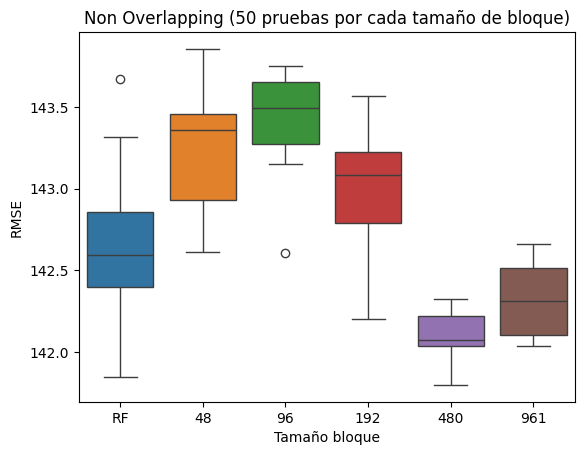

In [16]:
from matplotlib import pyplot as plt

all_arr, ticksIdx, ticksNames = getGraphData(precisionNonOverlapping)

sns.boxplot(data=all_arr)
plt.xticks(ticksIdx, ticksNames)
plt.title("Non Overlapping (50 pruebas por cada tamaño de bloque)")
plt.xlabel("Tamaño bloque")
plt.ylabel("RMSE")

In [ ]:
precisionMovingBlock = dict()
for block_size in blockSizes:
    precisionMovingBlock[block_size] = []
    for k in range(50):
        rmse0 = testRftsAndGetRmseByAlgorithm(dataset, daysOfBlocks, daysOfTraining, block_size, 1)
        print(f"RMSE: ({block_size}, {k})")
        print(rmse0)
        precisionMovingBlock[block_size].append(rmse0)

RMSE: (48, 0)
142.11251791690606
RMSE: (48, 1)
142.61530998310565
RMSE: (48, 2)
142.72001320732022
RMSE: (48, 3)
142.15883436092327
RMSE: (48, 4)
142.08059422309276
RMSE: (48, 5)
141.86160910273597
RMSE: (48, 6)
142.25587554863074
RMSE: (48, 7)
142.2953116614748
RMSE: (48, 8)
141.87127596698758
RMSE: (48, 9)
141.83976840646923
RMSE: (96, 0)
142.17804501193135
RMSE: (96, 1)
141.99623805521463
RMSE: (96, 2)
142.41708523446033
RMSE: (96, 3)
142.12407152788745
RMSE: (96, 4)
141.94740068356708
RMSE: (96, 5)
141.5454028076221
RMSE: (96, 6)
142.21599101063046
RMSE: (96, 7)
141.8855528944915
RMSE: (96, 8)
142.29014837594974
RMSE: (96, 9)
141.6048166701576
RMSE: (192, 0)
142.41070811129367
RMSE: (192, 1)
143.0388610493458
RMSE: (192, 2)
141.5453753069205
RMSE: (192, 3)
141.98786486260624
RMSE: (192, 4)
142.65173840252868
RMSE: (192, 5)
141.84991457862432
RMSE: (192, 6)
141.96347631395346
RMSE: (192, 7)
142.09768343413066
RMSE: (192, 8)
141.63578548496398
RMSE: (192, 9)
141.81102993267461
RMSE: 

Text(0, 0.5, 'RMSE')

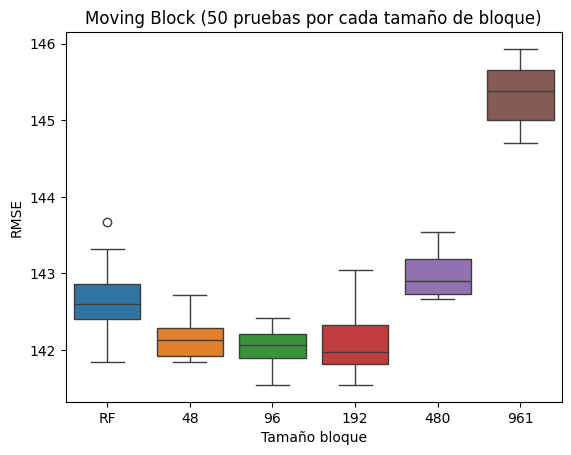

In [18]:
all_arr, ticksIdx, ticksNames = getGraphData(precisionMovingBlock)

sns.boxplot(data=all_arr)
plt.xticks(ticksIdx, ticksNames)
plt.title("Moving Block (50 pruebas por cada tamaño de bloque)")
plt.xlabel("Tamaño bloque")
plt.ylabel("RMSE")

In [ ]:
precisionCircularBlock = dict()
for block_size in blockSizes:
    precisionCircularBlock[block_size] = []
    for k in range(50):
        rmse0 = testRftsAndGetRmseByAlgorithm(dataset, daysOfBlocks, daysOfTraining, block_size, 2)
        print(f"RMSE: ({block_size}, {k})")
        print(rmse0)
        precisionCircularBlock[block_size].append(rmse0)

RMSE: (48, 0)
142.37818037768028
RMSE: (48, 1)
141.96591681460026
RMSE: (48, 2)
142.27926556153074
RMSE: (48, 3)
142.60865610604446
RMSE: (48, 4)
142.50782623140734
RMSE: (48, 5)
142.29705541514664
RMSE: (48, 6)
142.2776453045604
RMSE: (48, 7)
142.27120798703254
RMSE: (48, 8)
142.31934325999651
RMSE: (48, 9)
142.6557942701689
RMSE: (96, 0)
142.61463489244935
RMSE: (96, 1)
142.00285450870993
RMSE: (96, 2)
142.78402444097438
RMSE: (96, 3)
142.3666512892287
RMSE: (96, 4)
142.4652263457083
RMSE: (96, 5)
141.6688275810445
RMSE: (96, 6)
142.28261028250142
RMSE: (96, 7)
142.06398280038178
RMSE: (96, 8)
142.07063764418925
RMSE: (96, 9)
141.8852576094118
RMSE: (192, 0)
142.9820548836814
RMSE: (192, 1)
142.15036214704003
RMSE: (192, 2)
141.8932470940324
RMSE: (192, 3)
142.6689771484463
RMSE: (192, 4)
141.63381501730655
RMSE: (192, 5)
142.75081030447024
RMSE: (192, 6)
142.41169569286322
RMSE: (192, 7)
142.3621720622766
RMSE: (192, 8)
142.27738545384673
RMSE: (192, 9)
142.79785540065933
RMSE: (480

Text(0, 0.5, 'RMSE')

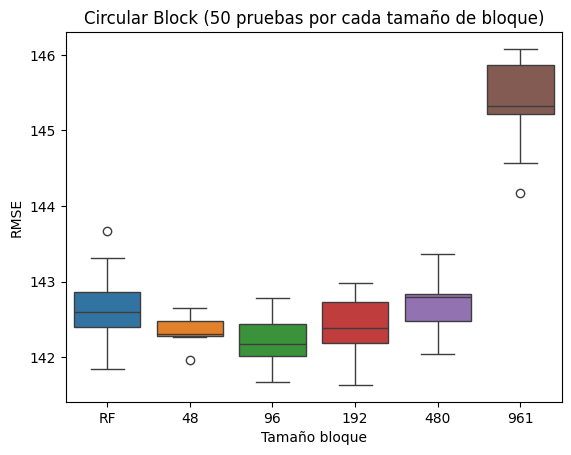

In [20]:
all_arr, ticksIdx, ticksNames = getGraphData(precisionCircularBlock)

sns.boxplot(data=all_arr)
plt.xticks(ticksIdx, ticksNames)
plt.title("Circular Block (50 pruebas por cada tamaño de bloque)")
plt.xlabel("Tamaño bloque")
plt.ylabel("RMSE")

Text(38.222222222222214, 0.5, 'RMSE')

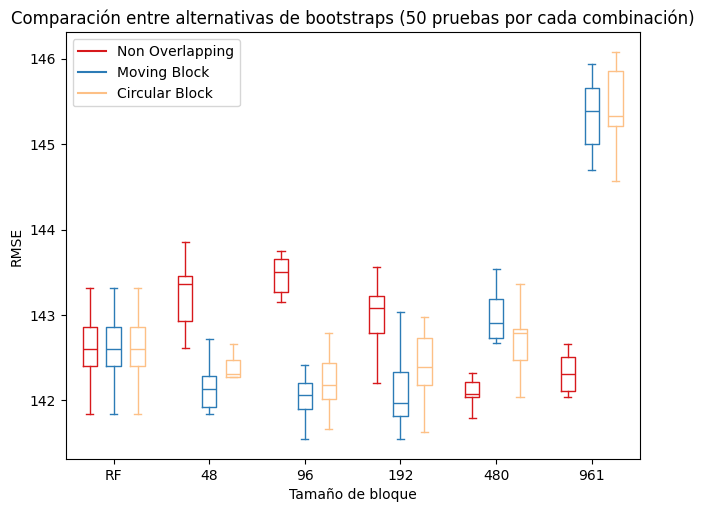

In [21]:
all_arr, ticksIdx, ticksNames = getGraphData(precisionNonOverlapping)
all_arr1, ticksIdx, ticksNames = getGraphData(precisionMovingBlock)
all_arr2, ticksIdx, ticksNames = getGraphData(precisionCircularBlock)

def set_box_color(bp, color):
    plt.setp(bp['boxes'], color=color)
    plt.setp(bp['whiskers'], color=color)
    plt.setp(bp['caps'], color=color)
    plt.setp(bp['medians'], color=color)

plt.figure()

bp0 = plt.boxplot(all_arr, positions=np.array(range(len(all_arr)))*2.0-0.5, sym='', widths=0.3)
bp1 = plt.boxplot(all_arr1, positions=np.array(range(len(all_arr1)))*2.0, sym='', widths=0.3)
bp2 = plt.boxplot(all_arr2, positions=np.array(range(len(all_arr1)))*2.0+0.5, sym='', widths=0.3)
set_box_color(bp0, '#D7191C') # colors are from http://colorbrewer2.org/
set_box_color(bp1, '#2C7BB6')
set_box_color(bp2, '#fdc086')

# draw temporary red and blue lines and use them to create a legend
plt.plot([], c='#D7191C', label='Non Overlapping')
plt.plot([], c='#2C7BB6', label='Moving Block')
plt.plot([], c='#fdc086', label='Circular Block')
plt.legend()

plt.xticks(range(0, len(ticksNames) * 2, 2), ticksNames)
# plt.xlim(-2, len(ticks)*2)
#plt.ylim(34, 55)
plt.tight_layout()
plt.title("Comparación entre alternativas de bootstraps (50 pruebas por cada combinación)")
plt.xlabel("Tamaño de bloque")
plt.ylabel("RMSE")